In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import *

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
df_game = spark.read.csv("./1. Query/Game.csv", inferSchema=True, header=True)
df_game.show()

+------+-----------------+
|GameID|         GameName|
+------+-----------------+
| GA001|       Elden Ring|
| GA002|   Genshin Impact|
| GA003|       Elden Ring|
| GA004|Honkai: Star Rail|
| GA005|           Dota 2|
| GA006|          FIFA 23|
| GA007|League of Legends|
| GA008|       Elden Ring|
| GA009|      Overwatch 2|
| GA010|Honkai: Star Rail|
| GA011|           Roblox|
| GA012|        Minecraft|
| GA013|           Roblox|
| GA014|       Elden Ring|
| GA015|             PUBG|
| GA016|         Valorant|
| GA017|           Dota 2|
| GA018|         Valorant|
| GA019|         Valorant|
| GA020|            CS:GO|
+------+-----------------+



In [4]:
df_customer = spark.read.csv("./1. Query/Customer.csv", inferSchema=True, header=True)

In [5]:
df_product = spark.read.csv("./1. Query/Product.csv", inferSchema=True, header=True)

In [6]:
df_th = spark.read.csv("./1. Query/TransactionHeader.csv", inferSchema=True, header=True)

In [7]:
df_td = spark.read.csv("./1. Query/TransactionDetail.csv", inferSchema=True, header=True)

In [8]:
df_game.registerTempTable("MsGame")
df_customer.registerTempTable("MsCustomer")
df_product.registerTempTable("MsProduct")
df_th.registerTempTable("TransactionHeader")
df_td.registerTempTable("TransactionDetail")

In [9]:
query1 = spark.sql("""
    SELECT GameName, SUM(quantity) as TotalSold
    FROM MsGame mg
    JOIN MsProduct mp ON mp.GameID = mg.GameID
    JOIN TransactionDetail td ON td.ProductID = mp.ProductID
    WHERE Quantity > 1
    GROUP BY GameName
    ORDER BY TotalSold desc
""")

query1.show()

+-----------------+---------+
|         GameName|TotalSold|
+-----------------+---------+
|       Elden Ring|       89|
|           Roblox|       89|
|         Valorant|       88|
|            CS:GO|       83|
|           Dota 2|       41|
|          FIFA 23|       28|
|        Minecraft|       15|
|League of Legends|       14|
|             PUBG|       12|
|Honkai: Star Rail|        9|
|      Overwatch 2|        8|
|   Genshin Impact|        4|
+-----------------+---------+



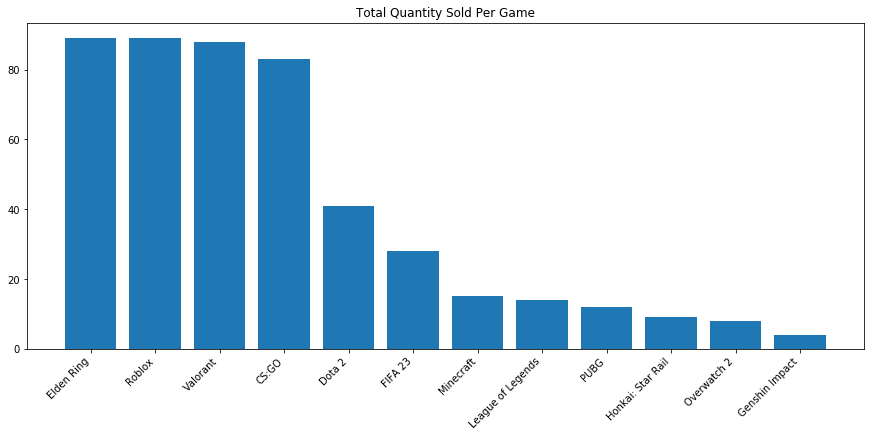

In [10]:
query1Pandas = query1.toPandas()

plt.figure(figsize = (15,6))
plt.title("Total Quantity Sold Per Game")
plt.bar(query1Pandas['GameName'],query1Pandas['TotalSold'])
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [11]:
query2 = spark.sql("""
    select ProductName,
    SUM(Quantity*Price) as TotalRevenue
    from TransactionDetail td
    JOIN MsProduct mp on mp.ProductID = td.ProductID
    where price > 1000 and quantity >= 2
    group by ProductName
    order by TotalRevenue desc
    limit 10
""")
query2.show()

+--------------------+------------+
|         ProductName|TotalRevenue|
+--------------------+------------+
|   CS:GO - Character|      140468|
|  Roblox - Character|      114104|
|     Valorant - Skin|       84316|
|   Valorant - Weapon|       74272|
|Elden Ring - Char...|       63468|
|       Roblox - Skin|       60816|
| Valorant - XP Boost|       50570|
|Minecraft - XP Boost|       49125|
|  PUBG - Battle Pass|       48612|
|      CS:GO - Weapon|       47198|
+--------------------+------------+



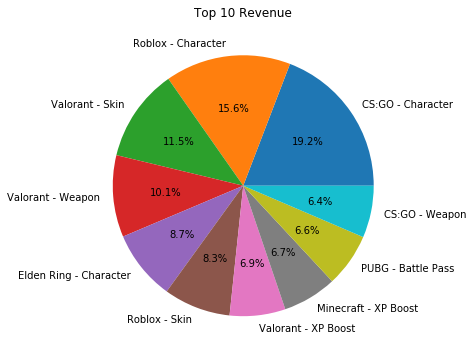

In [12]:
query2Pandas = query2.toPandas()

plt.figure(figsize = (20,6))
plt.title("Top 10 Revenue")
plt.pie(query2Pandas['TotalRevenue'],labels = query2Pandas['ProductName'], autopct='%1.1f%%')
plt.show()

In [13]:
query3 = spark.sql("""
    select 
        mg.GameName,
        SUM(Quantity*Price) as TotalRevenue,
        CASE 
            when sum(Quantity*Price) >=10000 then 'High Revenue'
            when sum(Quantity*Price) > 5000 then 'Medium Revenue'
            else 'Low Revenue' end as GameCategory
    from 
        MsGame mg
    JOIN 
        MsProduct mp 
    on 
        mp.GameID = mg.GameID
    JOIN
        TransactionDetail td
    on 
        td.ProductID = mp.ProductID
    WHERE 
        price>500
    group by GameName
    order by TotalRevenue desc
""")
query3.show()

+-----------------+------------+------------+
|         GameName|TotalRevenue|GameCategory|
+-----------------+------------+------------+
|            CS:GO|      333935|High Revenue|
|         Valorant|      293502|High Revenue|
|       Elden Ring|      285897|High Revenue|
|           Roblox|      280795|High Revenue|
|           Dota 2|      118015|High Revenue|
|        Minecraft|       52400|High Revenue|
|             PUBG|       52058|High Revenue|
|          FIFA 23|       49818|High Revenue|
|      Overwatch 2|       42944|High Revenue|
|Honkai: Star Rail|       39124|High Revenue|
|   Genshin Impact|       12745|High Revenue|
|League of Legends|       12256|High Revenue|
+-----------------+------------+------------+



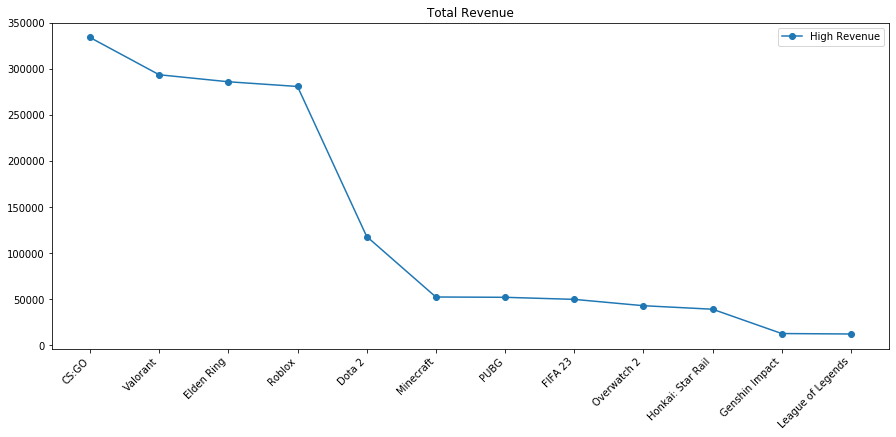

In [14]:
query3Pandas = query3.toPandas()

plt.figure(figsize = (15,6))
plt.title("Total Revenue")
for category in query3Pandas['GameCategory'].unique():
    subset = query3Pandas[query3Pandas["GameCategory"]==category]
    plt.plot(query3Pandas['GameName'], query3Pandas['TotalRevenue'],
        marker = "o", linestyle="-", label = category)
    plt.xticks(rotation = 45, ha = 'right')
    plt.legend()
    plt.show()

In [15]:
from pyspark.sql.functions import when
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler #penting
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.clustering import KMeans

In [16]:
df_train = spark.read.csv("./2. Classification/train.csv", inferSchema=True, header=True)
df_test = spark.read.csv("./2. Classification/test.csv", inferSchema=True, header=True)

In [17]:
df_train = df_train.dropna()
df_test = df_test.dropna()
df_train.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
| 39|  M|          NAP|      120|        339|        0| 

In [18]:
def encode(df):
    return (
    df.withColumn("Sex",
         when(df["Sex"] == "M", 0)
        .when(df['Sex'] == "F", 1)
    ).withColumn("ChestPainType",
        when(df['ChestPaintype'] == 'ATA',0)
        .when(df['ChestPaintype'] == 'ASY',1)
         .when(df['ChestPaintype'] == 'NAP',2)
        .when(df['ChestPaintype'] == 'TA',3)
    ).withColumn("RestingECG",
        when(df['RestingECG'] == 'Normal',0)
        .when(df['RestingECG'] == 'ST',1)
         .when(df['RestingECG'] == 'LVH',2)
    ).withColumn("ExerciseAngina",
        when(df['ExerciseAngina'] == 'N',0)
        .when(df['ExerciseAngina'] == 'Y',1)
    ).withColumn("ST_Slope",
        when(df['ST_Slope'] == 'Down',0)
        .when(df['ST_Slope'] == 'Flat',1)
         .when(df['ST_Slope'] == 'Up',1)        
    )
    
    )

In [19]:
df_train = encode(df_train)
df_test = encode(df_test)

In [20]:
df_train.show()
df_test.show()

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  0|            0|      140|        289|        0|         0|  172|             0|    0.0|       1|           0|
| 49|  1|            2|      160|        180|        0|         0|  156|             0|    1.0|       1|           1|
| 37|  0|            0|      130|        283|        0|         1|   98|             0|    0.0|       1|           0|
| 48|  1|            1|      138|        214|        0|         0|  108|             1|    1.5|       1|           1|
| 54|  0|            2|      150|        195|        0|         0|  122|             0|    0.0|       1|           0|
| 39|  0|            2|      120|        339|        0| 

In [21]:
feat_cols = [
    "Age","Sex",
    "ChestPainType","RestingBP",
    "Cholesterol","FastingBS"
    ,"RestingECG","MaxHR"
    ,"ExerciseAngina","Oldpeak"
    ,"ST_Slope"
]

df_train = VectorAssembler(inputCols=feat_cols, outputCol="vector" ).transform(df_train)
df_train = StandardScaler(inputCols="vector", outputCol="features" ).fit(df_train).transform(df_train)

TypeError: __init__() got an unexpected keyword argument 'inputCols'